# Real Estate Investment Analysis: EDA Report


**Investment Analysis for Zachary Brooks, sellers**  
_He invests in historical houses, best neighbourhoods, high profits, best timing within a year, should renovate?_

**Hypothesis 1: Renovation impact on price**
Hypothesis: Old homes (yr_built > 50?) that have been renovated (yr_renovated > 0) sell at significantly higher prices than comparable non-renovated homes.
Is there an optimal point in years to renovate? (Ie: how old should be the house relative to its price where renovation makes sense?)
Josefa's feedback: what does "significantly higher prices" mean?

**Hypothesis 2: Seasonality in sale prices**
Hypothesis: Homes sold in peak real estate months (say for example May–July?) achieve higher average prices than those sold in off-peak months (say for example November–January?)
Can he use certain months to renovate and others to sell to maximise profits and minimise downtime?

**Hypothesis 3: Neighbourhood density and price**
Hypothesis: Old homes (yr_built > 50?) in highly dense areas (ie: living area tends to plot area) that have not being renovated can be bought at lower price than comparable new properties 
How do I know if there are historical? Dense areas are city centres? City centres have historical houses?


### 🎯 Key Findings
Based on analysis of 21,597 house sales in King County I found 3 suggestions for investment strategies:

| Strategy | Finding | Business Impact |
|----------|---------|----------------|
| **Renovation Strategy** | Renovated old homes sell for **52.4% more** (+$260,066) | **HIGH IMPACT** - Strong ROI potential |
| **Seasonal Timing** | Peak months command **5.1% premium** (+$26,850) | **MODERATE IMPACT** - Timing optimization |
| **Location Strategy** | Old houses in dense areas are **32.5% pricier** (+$192,175) | **INSIGHT** - Premium locations identified |

---


## Setup

In [1]:
# Enhanced setup for business analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter

# Business-focused styling
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
warnings.filterwarnings('ignore')

# Enhanced display settings for business presentation
pd.set_option('display.float_format', '${:,.0f}'.format)
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 11

# Currency formatter for better business readability
def currency_formatter(x, p):
    return f"${x/1000:.0f}K"

def percentage_formatter(x, p):
    return f"{x:.1f}%"

print("Business analytics environment ready!")
print("Focus: Actionable insights for real estate investment")

Business analytics environment ready!
Focus: Actionable insights for real estate investment


In [2]:
# Connect and mport info from SQL database
import os # provides functions for interacting with operating system
from dotenv import load_dotenv # reads key-value pairs from a .env file and can set them as environment variables

load_dotenv() # takes environment variables from .env

DATABASE = os.getenv('DATABASE')
USER_DB = 'thyme'
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')
from sqlalchemy import create_engine # for creating an engine

#read the database string DB_STRING from the .env
load_dotenv()

DB_STRING = os.getenv('DB_STRING') # gets database string DB_STRING from .env file and assigns it as value for new variable DB_STRING

db = create_engine(DB_STRING) # creates engine from database string DB_STRING
#import the data to a pandas dataframe
query_string = "SELECT * FROM eda.king_county_house_details hd LEFT JOIN eda.king_county_house_sales hs ON hd.id = hs.house_id;" # write SQL-query into variable query_string
df_sqlalchemy = pd.read_sql(query_string, db) # read queried data from SQL database into pandas dataframe

#export the data to a csv-file
df_sqlalchemy.to_csv('data/eda_dataset.csv',index=False)


In [12]:
# Load and overview the real estate dataset
df = pd.read_csv('data/eda_dataset.csv')

print("🏠 KING COUNTY REAL ESTATE DATASET")
print("=" * 40)
print(f"Total Properties: {len(df):,}")
print(f"Time Period: {pd.to_datetime(df['date']).min().strftime('%B %Y')} - {pd.to_datetime(df['date']).max().strftime('%B %Y')}")
print(f"Price Range: ${df['price'].min():,} - ${df['price'].max():,}")
print(f"Avg Square Feet: {df['sqft_living'].mean():.0f}")
print(f"Avg Bedrooms: {df['bedrooms'].mean():.1f}")

# Quick market overview
print("\n MARKET OVERVIEW")
print("=" * 20)
print(f"Median Price: ${df['price'].median():,}")
print(f"Mean Price: ${df['price'].mean():,.0f}")
print(f"Price Std Dev: ${df['price'].std():,.0f}")

🏠 KING COUNTY REAL ESTATE DATASET
Total Properties: 21,597
Time Period: May 2014 - May 2015
Price Range: $78,000.0 - $7,700,000.0
Avg Square Feet: 2080
Avg Bedrooms: 3.4

 MARKET OVERVIEW
Median Price: $450,000.0
Mean Price: $540,297
Price Std Dev: $367,368


In [15]:
# Business-focused data preparation

# Clean data
columns_to_drop = ['id', 'id.1']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Handle missing values strategically
df['waterfront'].fillna(0, inplace=True)  # Assume no waterfront if not specified
df['view'].fillna(0, inplace=True)  # Assume no special view
df['sqft_basement'].fillna(0, inplace=True)  # Assume no basement
df['yr_renovated'].fillna(0, inplace=True)  # Assume not renovated

# Extra setup because we need some variables for calculations in the hypothesis analysis.
df['date'] = pd.to_datetime(df['date'])
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month
df['house_age'] = df['sale_year'] - df['yr_built']

# Investment-focused categorizations
df['renovated'] = np.where(df['yr_renovated'] > 0, 1, 0)
df['age_category'] = pd.cut(df['house_age'], 
                           bins=[-1, 10, 30, 50, 100, 150], 
                           labels=['New (0-10)', 'Modern (11-30)', 'Mature (31-50)', 'Old (51-100)', 'Historic (100+)'])

# Price per square foot (key business metric)
df['price_per_sqft'] = df['price'] / df['sqft_living']

# Density ratio for location analysis
df['density_ratio'] = df['sqft_living'] / df['sqft_lot']

# Investment quality scoring
df['is_old'] = np.where(df['house_age'] >= 50, 1, 0) # Is the house at least 50 years old?” – 1 means yes (an older property), 0 means no
df['is_large'] = np.where(df['sqft_living'] >= df['sqft_living'].median(), 1, 0) # Is the living‑area size at or above the median size of the whole dataset?” – 1 means large (above‑median square footage), 0 means smaller than median.
df['is_premium'] = np.where(df['price'] >= df['price'].quantile(0.75), 1, 0) # Is the asking/sale price in the top 25 percent of all prices?” – 1 means premium‑priced, 0 means not premium.

print("Setup done!")

Setup done!


---

# HYPOTHESIS 1: Renovation Impact Strategy

**Business Question**: *Should Zachary invest in renovating old properties?*

**Hypothesis**: Old homes (≥50 years) that have been renovated sell at significantly higher prices than comparable non-renovated homes.


In [17]:
# HYPOTHESIS 1: Detailed Investment Analysis
print("ANALYSIS")
print("=" * 35)

# Focus on old houses (≥50 years) - our target market
old_houses = df[df['house_age'] >= 50].copy()
renovated_old = old_houses[old_houses['renovated'] == 1]
non_renovated_old = old_houses[old_houses['renovated'] == 0]

# Market size analysis
print(f"MARKET OPPORTUNITY")
print(f"Total old houses (≥50 years): {len(old_houses):,}")
print(f"Already renovated: {len(renovated_old):,} ({len(renovated_old)/len(old_houses)*100:.1f}%)")
print(f"NOT renovated: {len(non_renovated_old):,} ({len(non_renovated_old)/len(old_houses)*100:.1f}%)")
print(f"\n OPPORTUNITY: {len(non_renovated_old):,} unrenovated old properties available!")

# Investment returns analysis
print(f"\n FINANCIAL IMPACT")
renovated_avg = renovated_old['price'].mean()
non_renovated_avg = non_renovated_old['price'].mean()
price_premium = renovated_avg - non_renovated_avg
roi_percentage = (price_premium / non_renovated_avg) * 100

print(f"Average Price - Renovated: ${renovated_avg:,.0f}")
print(f"Average Price - Non-renovated: ${non_renovated_avg:,.0f}")
print(f"PREMIUM for renovation: ${price_premium:,.0f} (+{roi_percentage:.1f}%)")

# Statistical measures
print(f"\n  DISTRIBUTION ANALYSIS")
print(f"Renovated - Median: ${renovated_old['price'].median():,.0f}")
print(f"Non-renovated - Median: ${non_renovated_old['price'].median():,.0f}")
print(f"Correlation (renovation vs price): {old_houses['renovated'].corr(old_houses['price']):.3f}")

ANALYSIS
MARKET OPPORTUNITY
Total old houses (≥50 years): 8,657
Already renovated: 642 (7.4%)
NOT renovated: 8,015 (92.6%)

 OPPORTUNITY: 8,015 unrenovated old properties available!

 FINANCIAL IMPACT
Average Price - Renovated: $756,702
Average Price - Non-renovated: $496,635
PREMIUM for renovation: $260,066 (+52.4%)

  DISTRIBUTION ANALYSIS
Renovated - Median: $608,452
Non-renovated - Median: $425,000
Correlation (renovation vs price): 0.192


##  **Visualization 1: Renovation Impact Analysis**

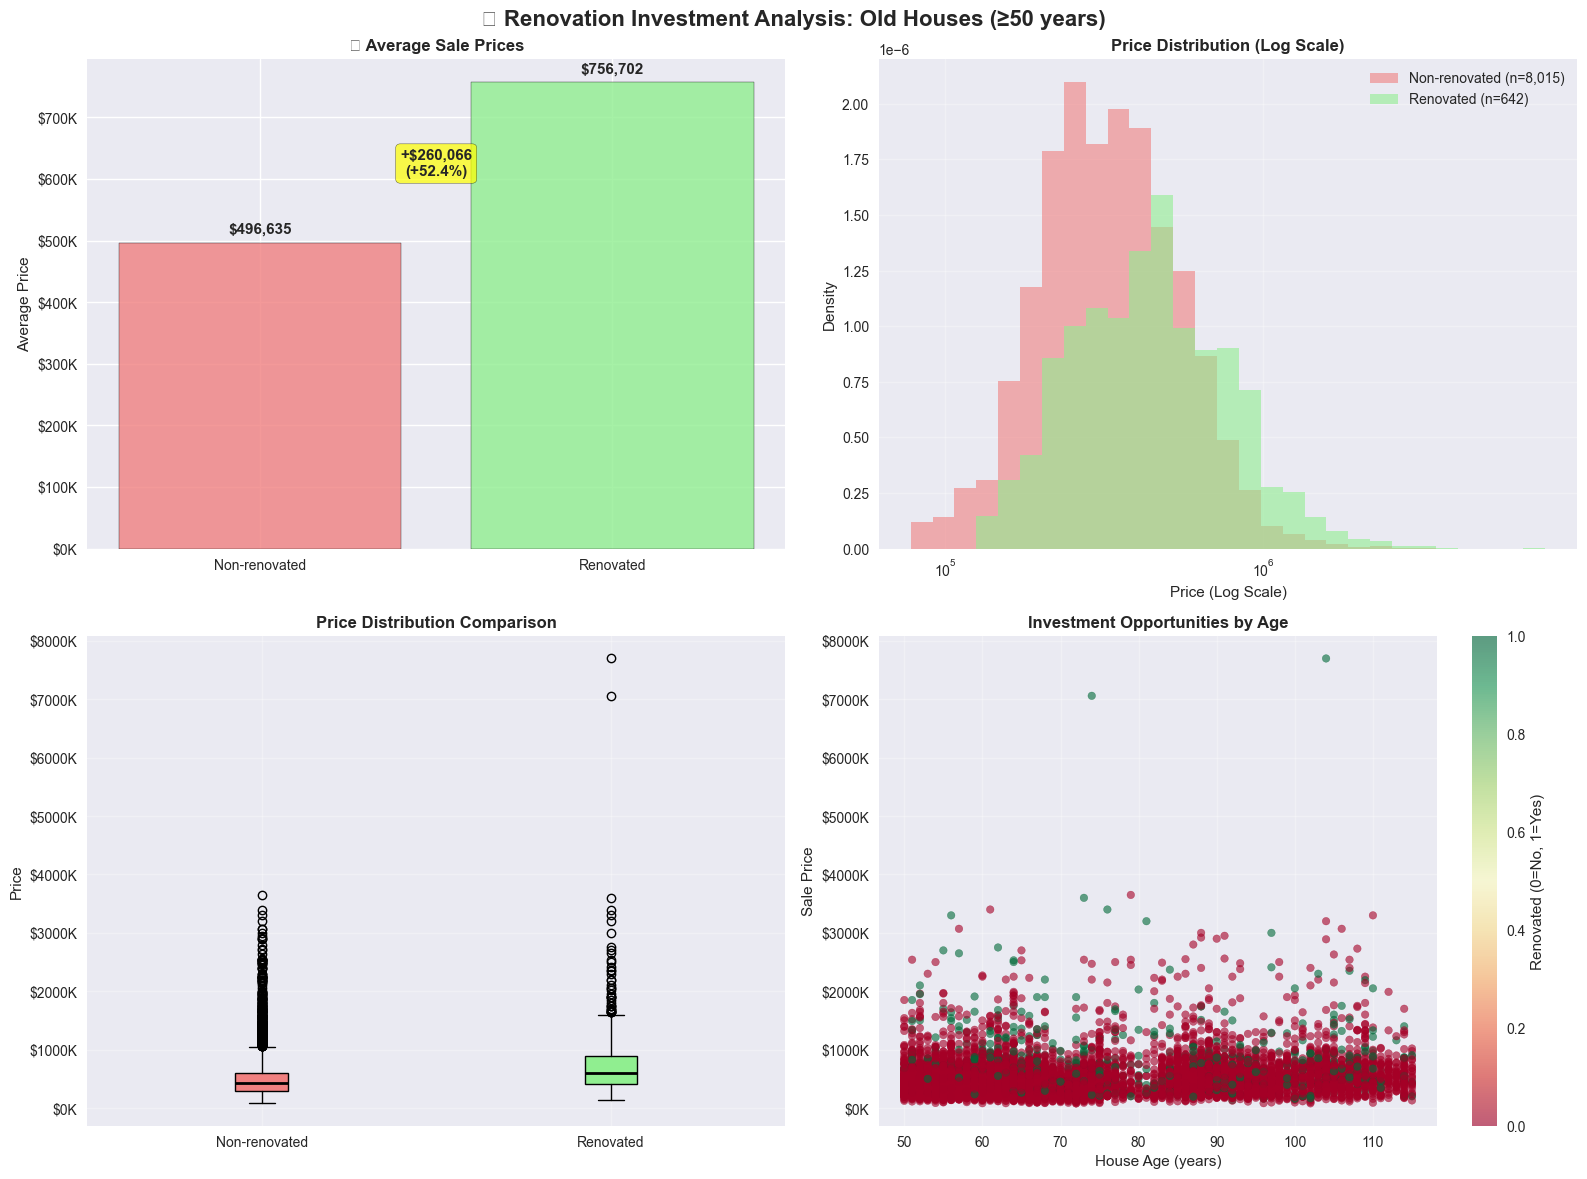

In [ ]:
# ENHANCED VISUALIZATION 1: Business-focused comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('💰 Renovation Investment Analysis: Old Houses (≥50 years)', fontsize=16, fontweight='bold')

# 1. Clean bar chart for average prices
categories = ['Non-renovated', 'Renovated']
avg_prices = [non_renovated_avg, renovated_avg]
colors = ['lightcoral', 'lightgreen']

bars1 = ax1.bar(categories, avg_prices, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Average Sale Prices', fontweight='bold')
ax1.set_ylabel('Average Price')
ax1.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

# Add value labels on bars
for bar, price in zip(bars1, avg_prices):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000, 
             f'${price:,.0f}', ha='center', va='bottom', fontweight='bold')

# Add premium annotation
ax1.annotate(f'+${price_premium:,.0f}\n(+{roi_percentage:.1f}%)', 
             xy=(0.5, max(avg_prices)*0.8), ha='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
             fontsize=11, fontweight='bold')

# 2. Better histogram with log scale and proper bins
# Use log transform to handle skewness
log_bins = np.logspace(np.log10(old_houses['price'].min()), 
                      np.log10(old_houses['price'].max()), 30)

ax2.hist(non_renovated_old['price'], bins=log_bins, alpha=0.6, 
         label=f'Non-renovated (n={len(non_renovated_old):,})', 
         color='lightcoral', density=True)
ax2.hist(renovated_old['price'], bins=log_bins, alpha=0.6, 
         label=f'Renovated (n={len(renovated_old):,})', 
         color='lightgreen', density=True)
ax2.set_xscale('log')
ax2.set_title('Price Distribution (Log Scale)', fontweight='bold')
ax2.set_xlabel('Price (Log Scale)')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Box plot with better scaling
box_data = [non_renovated_old['price'], renovated_old['price']]
bp = ax3.boxplot(box_data, labels=categories, patch_artist=True, 
                 medianprops=dict(color='black', linewidth=2))
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightgreen')
ax3.set_title('Price Distribution Comparison', fontweight='bold')
ax3.set_ylabel('Price')
ax3.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax3.grid(True, alpha=0.3)

# 4. Market opportunity scatter plot
ax4.scatter(old_houses['house_age'], old_houses['price'], 
           c=old_houses['renovated'], cmap='RdYlGn', alpha=0.6, s=30)
ax4.set_title('Investment Opportunities by Age', fontweight='bold')
ax4.set_xlabel('House Age (years)')
ax4.set_ylabel('Sale Price')
ax4.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
cbar = plt.colorbar(ax4.collections[0], ax=ax4)
cbar.set_label('Renovated (0=No, 1=Yes)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

#  HYPOTHESIS 2: Seasonal Timing Strategy

**Business Question**: *When should Zachary time his sales and renovations?*

**Hypothesis**: Homes sold in peak real estate months (May-July) achieve higher average prices than those sold in off-peak months (November-January).


In [21]:
# HYPOTHESIS 2: Seasonal Market Analysis
print("ANALYSIS")
print("=" * 40)

# Define seasons based on real estate market patterns
peak_months = [5, 6, 7]  # May-July (spring/summer selling season)
off_peak_months = [11, 12, 1]  # November-January (winter slow period)
shoulder_months = [2, 3, 4, 8, 9, 10]  # Transition periods

# Create enhanced season categories
def categorize_season(month):
    if month in peak_months:
        return 'Peak (May-Jul)'
    elif month in off_peak_months:
        return 'Off-Peak (Nov-Jan)'
    else:
        return 'Shoulder Season'

df['season_detailed'] = df['sale_month'].apply(categorize_season)
df['season'] = np.where(df['sale_month'].isin(peak_months), 'Peak',
                       np.where(df['sale_month'].isin(off_peak_months), 'Off-Peak', 'Other'))

# Market activity analysis
print(f"MARKET ACTIVITY BY SEASON")
season_activity = df['season_detailed'].value_counts()
for season, count in season_activity.items():
    percentage = (count / len(df)) * 100
    print(f"{season}: {count:,} sales ({percentage:.1f}%)")

# Price analysis by season
print(f"\n SEASONAL PRICING ANALYSIS")
peak_data = df[df['season'] == 'Peak']
offpeak_data = df[df['season'] == 'Off-Peak']
other_data = df[df['season'] == 'Other']

peak_avg = peak_data['price'].mean()
offpeak_avg = offpeak_data['price'].mean()
other_avg = other_data['price'].mean()

seasonal_premium = peak_avg - offpeak_avg
seasonal_percentage = (seasonal_premium / offpeak_avg) * 100

print(f"Peak Season Average: ${peak_avg:,.0f}")
print(f"Off-Peak Average: ${offpeak_avg:,.0f}")
print(f"Shoulder Season Average: ${other_avg:,.0f}")
print(f"\n SEASONAL ADVANTAGE: ${seasonal_premium:,.0f} (+{seasonal_percentage:.1f}%)")

# Market velocity analysis
print(f"\n MARKET VELOCITY")
monthly_volume = df.groupby('sale_month').size()
print(f"Peak months avg volume: {monthly_volume[peak_months].mean():.0f} sales/month")
print(f"Off-peak months avg volume: {monthly_volume[off_peak_months].mean():.0f} sales/month")

ANALYSIS
MARKET ACTIVITY BY SEASON
Shoulder Season: 10,937 sales (50.6%)
Peak (May-Jul): 6,803 sales (31.5%)
Off-Peak (Nov-Jan): 3,857 sales (17.9%)

 SEASONAL PRICING ANALYSIS
Peak Season Average: $551,054
Off-Peak Average: $524,204
Shoulder Season Average: $539,281

 SEASONAL ADVANTAGE: $26,850 (+5.1%)

 MARKET VELOCITY
Peak months avg volume: 2268 sales/month
Off-peak months avg volume: 1286 sales/month


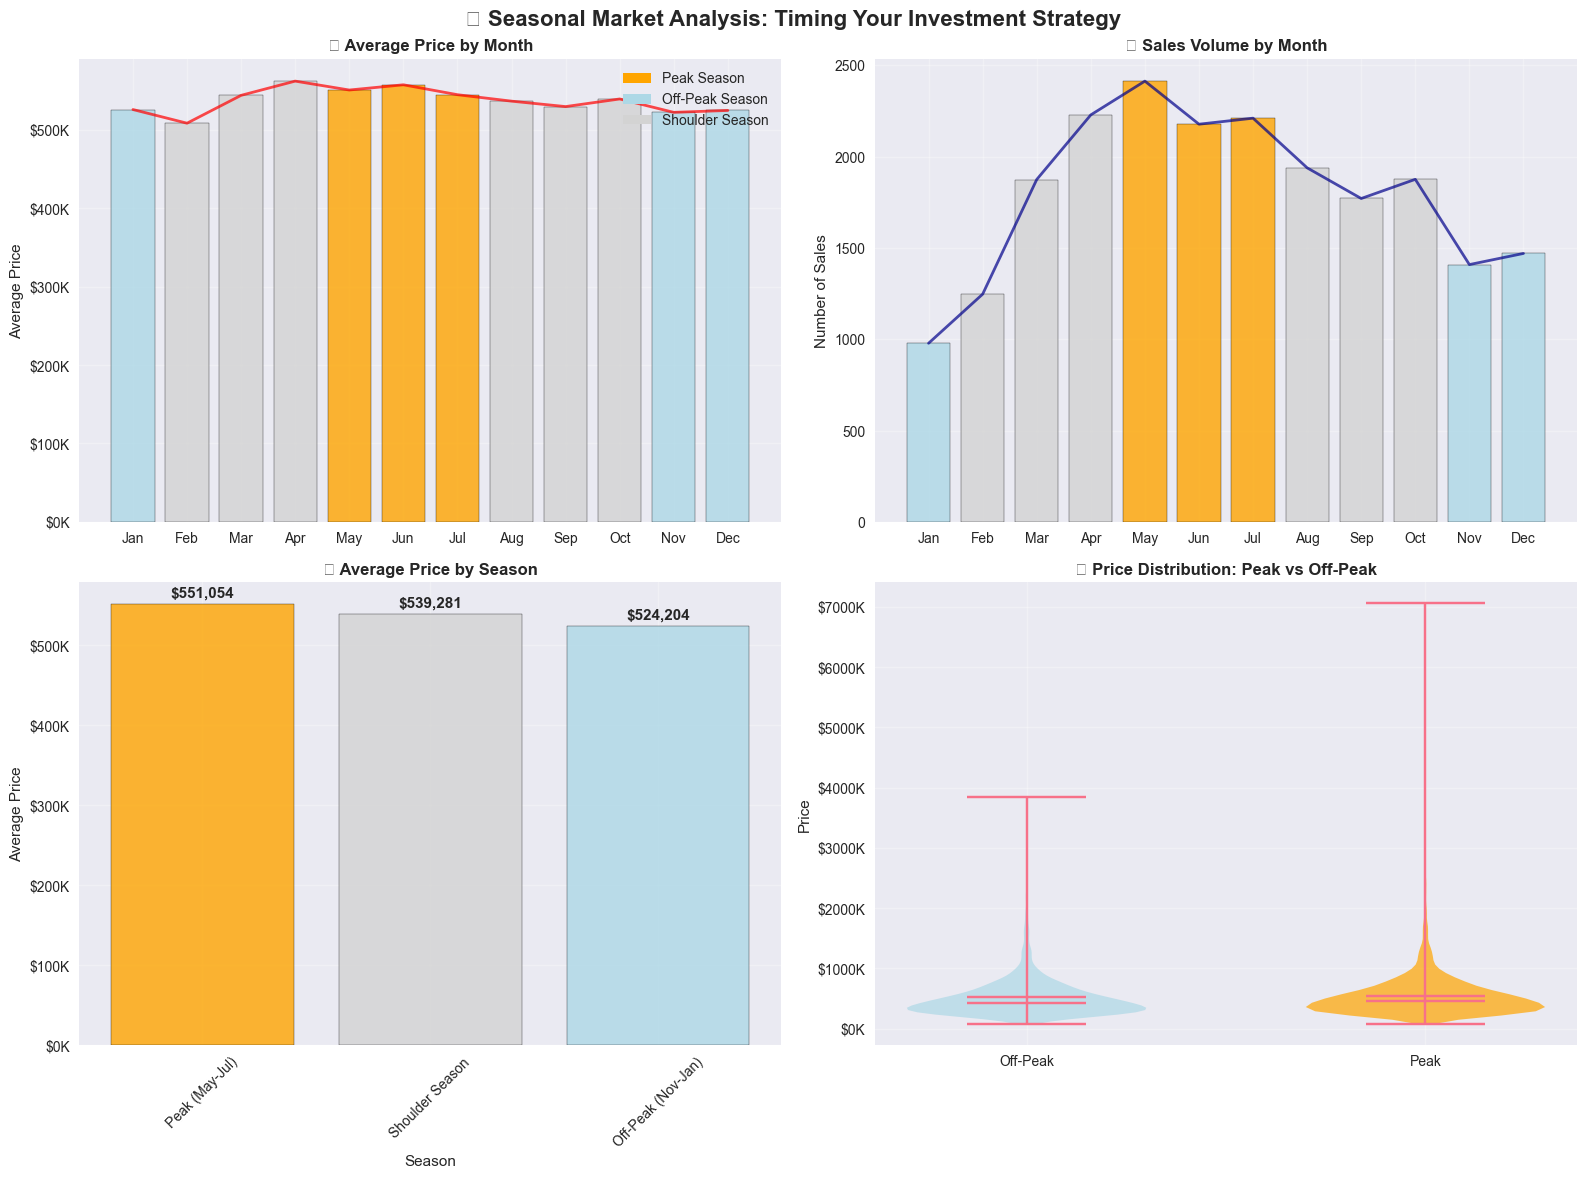

In [22]:
# ENHANCED SEASONAL VISUALIZATIONS
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📅 Seasonal Market Analysis: Timing Your Investment Strategy', fontsize=16, fontweight='bold')

# 1. Monthly price trends with clear peak highlighting
monthly_stats = df.groupby('sale_month')['price'].agg(['mean', 'count']).reset_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Color coding for seasons
colors = ['lightblue' if month in off_peak_months 
         else 'orange' if month in peak_months 
         else 'lightgray' for month in range(1, 13)]

bars = ax1.bar(month_names, monthly_stats['mean'], color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('🌟 Average Price by Month', fontweight='bold')
ax1.set_ylabel('Average Price')
ax1.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax1.grid(True, alpha=0.3)

# Add trend line
ax1.plot(month_names, monthly_stats['mean'], color='red', linewidth=2, alpha=0.7)

# Legend for seasons
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='orange', label='Peak Season'),
                  Patch(facecolor='lightblue', label='Off-Peak Season'),
                  Patch(facecolor='lightgray', label='Shoulder Season')]
ax1.legend(handles=legend_elements, loc='upper right')

# 2. Market volume by month
volume_colors = colors.copy()
bars2 = ax2.bar(month_names, monthly_stats['count'], color=volume_colors, alpha=0.8, edgecolor='black')
ax2.set_title('📊 Sales Volume by Month', fontweight='bold')
ax2.set_ylabel('Number of Sales')
ax2.grid(True, alpha=0.3)

# Add volume trend
ax2.plot(month_names, monthly_stats['count'], color='darkblue', linewidth=2, alpha=0.7)

# 3. Clean seasonal comparison
season_comparison = df.groupby('season_detailed')['price'].mean().sort_values(ascending=False)
season_colors = ['orange', 'lightgray', 'lightblue']

bars3 = ax3.bar(range(len(season_comparison)), season_comparison.values, 
                color=season_colors, alpha=0.8, edgecolor='black')
ax3.set_title('💰 Average Price by Season', fontweight='bold')
ax3.set_xlabel('Season')
ax3.set_ylabel('Average Price')
ax3.set_xticks(range(len(season_comparison)))
ax3.set_xticklabels(season_comparison.index, rotation=45)
ax3.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax3.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars3, season_comparison.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
             f'${value:,.0f}', ha='center', va='bottom', fontweight='bold')

# 4. Price distribution comparison (fixed skewness with violin plot)
seasonal_data = [df[df['season'] == 'Off-Peak']['price'],
                df[df['season'] == 'Peak']['price']]

parts = ax4.violinplot(seasonal_data, positions=[1, 2], widths=0.6, 
                      showmeans=True, showmedians=True)

# Color the violin plots
parts['bodies'][0].set_facecolor('lightblue')
parts['bodies'][1].set_facecolor('orange')
for pc in parts['bodies']:
    pc.set_alpha(0.7)

ax4.set_title('🎻 Price Distribution: Peak vs Off-Peak', fontweight='bold')
ax4.set_ylabel('Price')
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Off-Peak', 'Peak'])
ax4.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

# 🏙️ HYPOTHESIS 3: Location Density Strategy

**Business Question**: *Where should Zachary focus his investments geographically?*

**Hypothesis**: Old homes (≥50 years) in highly dense areas can be bought at lower prices than comparable new properties.


In [23]:
# HYPOTHESIS 3: Location Strategy Analysis
print("ANALYSIS")
print("=" * 45)

# Create density categories using quartiles
density_thresholds = df['density_ratio'].quantile([0.25, 0.5, 0.75]).values
df['density_category'] = pd.cut(df['density_ratio'], 
                               bins=[0, density_thresholds[0], density_thresholds[1], 
                                     density_thresholds[2], df['density_ratio'].max()],
                               labels=['Low Density', 'Medium-Low', 'Medium-High', 'High Density'])

# Focus on high-density areas (top 25%)
dense_threshold = df['density_ratio'].quantile(0.75)
dense_areas = df[df['density_ratio'] >= dense_threshold]
old_dense = dense_areas[dense_areas['is_old'] == 1]
new_dense = dense_areas[dense_areas['is_old'] == 0]

print(f"MARKET SEGMENTATION")
print(f"High-density threshold: {dense_threshold:.3f} (top 25%)")
print(f"Total properties in dense areas: {len(dense_areas):,}")
print(f"Old properties in dense areas: {len(old_dense):,}")
print(f"New properties in dense areas: {len(new_dense):,}")

# Price analysis - SURPRISING FINDING!
print(f"\n DENSITY PRICING ANALYSIS")
old_dense_avg = old_dense['price'].mean()
new_dense_avg = new_dense['price'].mean()
density_premium = old_dense_avg - new_dense_avg
density_percentage = (density_premium / new_dense_avg) * 100

print(f"Old houses in dense areas: ${old_dense_avg:,.0f}")
print(f"New houses in dense areas: ${new_dense_avg:,.0f}")
print(f"\n SURPRISING FINDING: Old houses cost ${density_premium:,.0f} MORE (+{density_percentage:.1f}%)")
print(f"\n INSIGHT: Dense areas have PREMIUM old properties, not bargains!")

# Analyze by density levels
print(f"\n ANALYSIS BY DENSITY LEVELS")
density_analysis = df.groupby(['density_category', 'is_old'])['price'].mean().unstack()
for density in density_analysis.index:
    if pd.notnull(density_analysis.loc[density, 0]) and pd.notnull(density_analysis.loc[density, 1]):
        old_price = density_analysis.loc[density, 1]
        new_price = density_analysis.loc[density, 0]
        premium = old_price - new_price
        premium_pct = (premium / new_price) * 100
        print(f"{density}: Old vs New = ${premium:,.0f} ({premium_pct:+.1f}%)")

ANALYSIS
MARKET SEGMENTATION
High-density threshold: 0.408 (top 25%)
Total properties in dense areas: 5,400
Old properties in dense areas: 1,439
New properties in dense areas: 3,961

 DENSITY PRICING ANALYSIS
Old houses in dense areas: $783,336
New houses in dense areas: $591,161

 SURPRISING FINDING: Old houses cost $192,175 MORE (+32.5%)

 INSIGHT: Dense areas have PREMIUM old properties, not bargains!

 ANALYSIS BY DENSITY LEVELS
Low Density: Old vs New = $-159,963 (-29.9%)
Medium-Low: Old vs New = $-50,938 (-10.2%)
Medium-High: Old vs New = $-2,200 (-0.4%)
High Density: Old vs New = $192,174 (+32.5%)


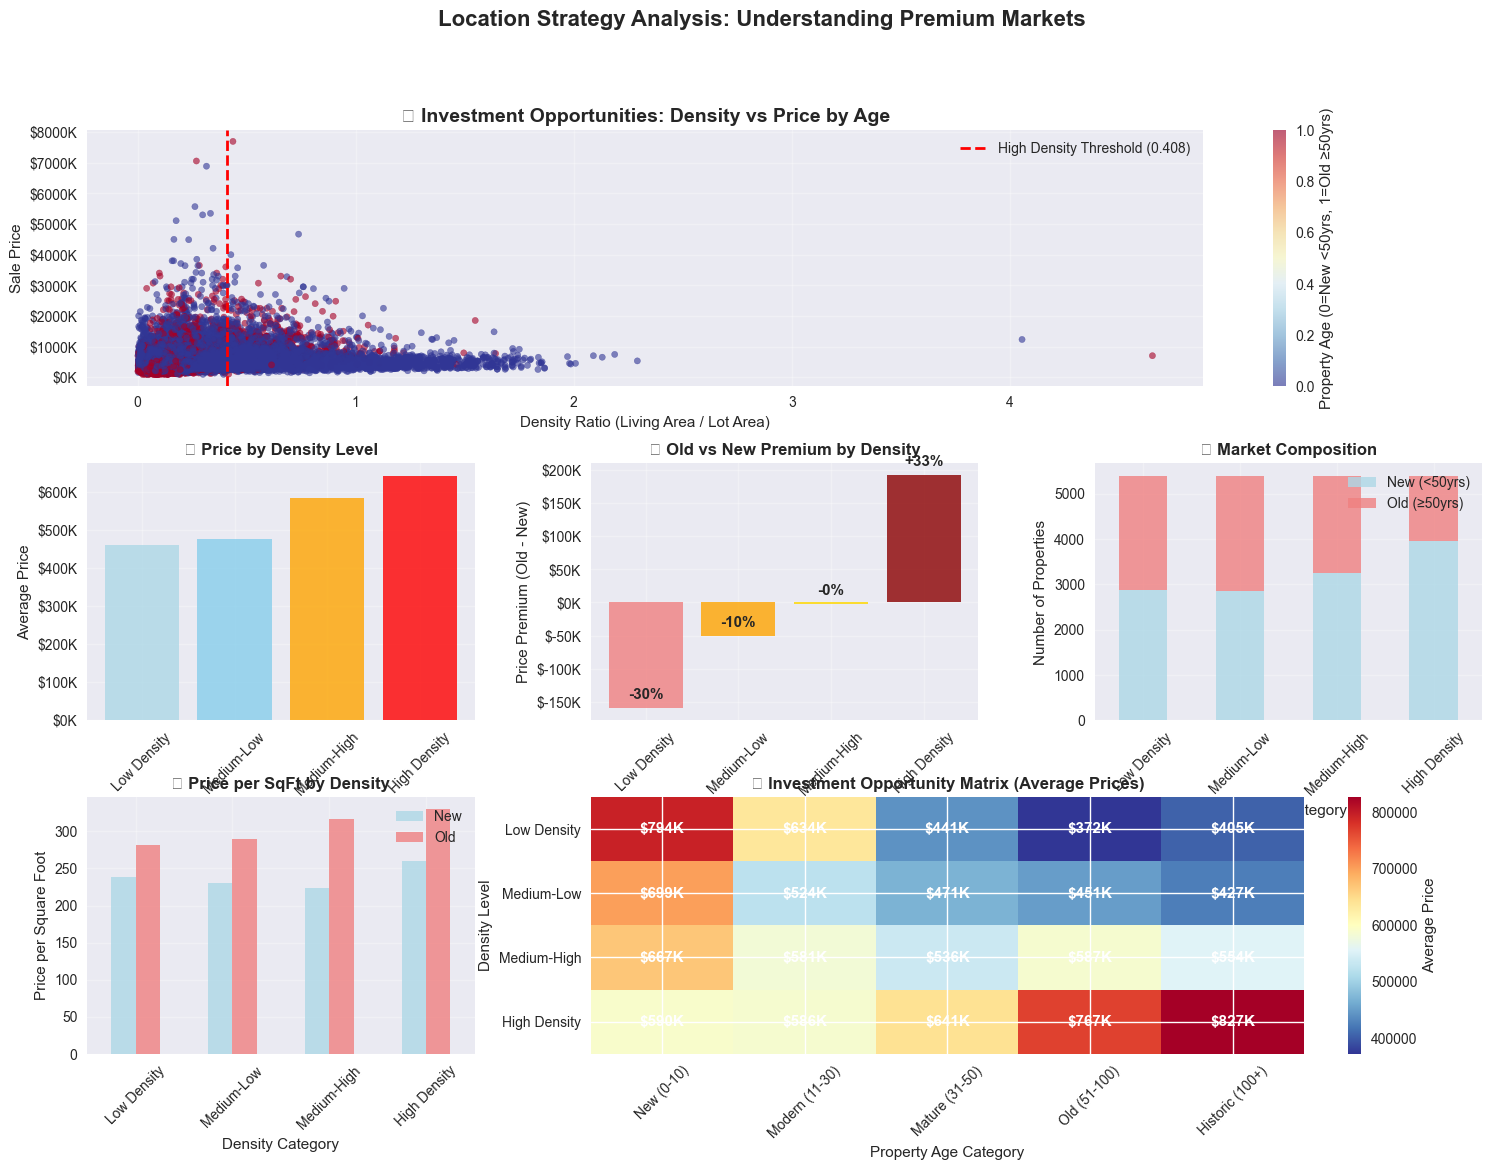

In [ ]:
# ENHANCED LOCATION STRATEGY VISUALIZATIONS
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Location Strategy Analysis: Understanding Premium Markets', fontsize=16, fontweight='bold')

# 1. Density vs Price Relationship (large plot)
ax1 = fig.add_subplot(gs[0, :])
scatter = ax1.scatter(df['density_ratio'], df['price'], 
                     c=df['is_old'], cmap='RdYlBu_r', alpha=0.6, s=20)
ax1.axvline(x=dense_threshold, color='red', linestyle='--', linewidth=2, 
           label=f'High Density Threshold ({dense_threshold:.3f})')
ax1.set_title('Investment Opportunities: Density vs Price by Age', fontweight='bold', fontsize=14)
ax1.set_xlabel('Density Ratio (Living Area / Lot Area)')
ax1.set_ylabel('Sale Price')
ax1.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Property Age (0=New <50yrs, 1=Old ≥50yrs)')

# 2. Average prices by density category
ax2 = fig.add_subplot(gs[1, 0])
density_avg = df.groupby('density_category')['price'].mean()
bars = ax2.bar(range(len(density_avg)), density_avg.values, 
               color=['lightblue', 'skyblue', 'orange', 'red'], alpha=0.8)
ax2.set_title('💰 Price by Density Level', fontweight='bold')
ax2.set_xlabel('Density Category')
ax2.set_ylabel('Average Price')
ax2.set_xticks(range(len(density_avg)))
ax2.set_xticklabels(density_avg.index, rotation=45)
ax2.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax2.grid(True, alpha=0.3)

# 3. Age vs Density premium analysis
ax3 = fig.add_subplot(gs[1, 1])
age_density_premium = df.groupby(['density_category', 'is_old'])['price'].mean().unstack()
age_density_premium['Premium'] = age_density_premium[1] - age_density_premium[0]
age_density_premium['Premium_Pct'] = (age_density_premium['Premium'] / age_density_premium[0]) * 100

bars = ax3.bar(range(len(age_density_premium)), age_density_premium['Premium'], 
               color=['lightcoral', 'orange', 'gold', 'darkred'], alpha=0.8)
ax3.set_title('📊 Old vs New Premium by Density', fontweight='bold')
ax3.set_xlabel('Density Category')
ax3.set_ylabel('Price Premium (Old - New)')
ax3.set_xticks(range(len(age_density_premium)))
ax3.set_xticklabels(age_density_premium.index, rotation=45)
ax3.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax3.grid(True, alpha=0.3)

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, age_density_premium['Premium_Pct'])):
    if not pd.isna(pct):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000,
                 f'{pct:+.0f}%', ha='center', va='bottom', fontweight='bold')

# 4. Market share analysis
ax4 = fig.add_subplot(gs[1, 2])
market_share = df.groupby(['density_category', 'is_old']).size().unstack()
market_share.plot(kind='bar', stacked=True, ax=ax4, 
                 color=['lightblue', 'lightcoral'], alpha=0.8)
ax4.set_title('🏠 Market Composition', fontweight='bold')
ax4.set_xlabel('Density Category')
ax4.set_ylabel('Number of Properties')
ax4.legend(['New (<50yrs)', 'Old (≥50yrs)'])
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# 5. Price per square foot analysis
ax5 = fig.add_subplot(gs[2, 0])
psf_analysis = df.groupby(['density_category', 'is_old'])['price_per_sqft'].mean().unstack()
psf_analysis.plot(kind='bar', ax=ax5, color=['lightblue', 'lightcoral'], alpha=0.8)
ax5.set_title('📏 Price per SqFt by Density', fontweight='bold')
ax5.set_xlabel('Density Category')
ax5.set_ylabel('Price per Square Foot')
ax5.legend(['New', 'Old'])
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# 6. Investment opportunity matrix
ax6 = fig.add_subplot(gs[2, 1:])

# Create opportunity matrix data
opportunity_data = df.groupby(['density_category', 'age_category']).agg({
    'price': 'mean',
    'price_per_sqft': 'mean'
}).round(0)

# Heatmap of average prices
pivot_prices = opportunity_data['price'].unstack()
im = ax6.imshow(pivot_prices.values, cmap='RdYlBu_r', aspect='auto')
ax6.set_title('🎯 Investment Opportunity Matrix (Average Prices)', fontweight='bold')
ax6.set_xlabel('Property Age Category')
ax6.set_ylabel('Density Level')
ax6.set_xticks(range(len(pivot_prices.columns)))
ax6.set_xticklabels(pivot_prices.columns, rotation=45)
ax6.set_yticks(range(len(pivot_prices.index)))
ax6.set_yticklabels(pivot_prices.index)

# Add value annotations
for i in range(len(pivot_prices.index)):
    for j in range(len(pivot_prices.columns)):
        if not pd.isna(pivot_prices.iloc[i, j]):
            ax6.text(j, i, f'${pivot_prices.iloc[i, j]/1000:.0f}K',
                    ha='center', va='center', color='white', fontweight='bold')

plt.colorbar(im, ax=ax6, label='Average Price')
plt.tight_layout()
plt.show()